## Machine Learning for EEG and SOT
### Tune the parameters using CV and test on a separate held out testing set 
### Rachneet Kaur

* Use EEG from the frontal channels as features and compare with EEG from F3/F4 channels as features
* Tune the model parameters using cross validation and then test on some held out set
* Put comparison table of ML algos and comparison of frontal and F3/F4 channels 
* Classify SOT in groups and model this as a binary classification problem 
* Find a rationale to classify SOT in 2 groups 
* Do a separate model for with perturbation trials and without perturbation trials and one model combining the both cases

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA as sklearnPCA
from scipy.stats import mode
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#ML methods imports 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from xgboost import XGBClassifier
import time 
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\Conference&Presenatations\\2019\\shou data\\"
file = "SOT_scores.csv"

In [4]:
file = pd.read_csv(data_dir + file)

In [5]:
file

,PID,SOT
0,101,85
1,102,75
2,105,80
3,106,86
4,109,81
5,111,70


In [6]:
#Making the dataframe with all features to work with 
#Data from participants HYA - 101, 102, 105, 106, 109, 111
#In total 38 trials 
index = ['101_trial1', '101_trial2', '101_trial3', '102_trial3', '102_trial4', '105_trial3', '105_trial4', '105_trial2', \
         '102_trial2', '106_trial1', '106_trial2', '106_trial3', '106_trial4', '109_trial1', '109_trial2', '109_trial3', \
        '111_trial1', '111_trial2', '111_trial3', '111_trial4']
label_list = [file.iloc[0,1]]*3 + [file.iloc[1,1]]*3 + [file.iloc[2,1]]*4 + [file.iloc[3,1]]*3 + [file.iloc[4,1]]*3 \
+ [file.iloc[5,1]]*4
labels = {'label':label_list}
data = pd.DataFrame(labels, index)

In [7]:
feat_dir = data_dir+ "HeightControlTrialWisePSD\\"
feat_101 = pd.read_csv(feat_dir+'HeightControl101_full_trial_features.csv')
feat_102 = pd.read_csv(feat_dir+'HeightControl102_full_trial_features.csv')
feat_105 = pd.read_csv(feat_dir+'HeightControl105_full_trial_features.csv')
feat_106 = pd.read_csv(feat_dir+'HeightControl106_full_trial_features.csv')
feat_109 = pd.read_csv(feat_dir+'HeightControl109_full_trial_features.csv')
feat_111 = pd.read_csv(feat_dir+'HeightControl111_full_trial_features.csv')
features_all = pd.concat((feat_101, feat_102, feat_105, feat_106, feat_109, feat_111))
features_all.index = data.index
complete_data = pd.concat((data, features_all), axis = 1)
complete_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
#20 rows of data with 315 features, label as SOT scores and trial ID to identify trials with and withour perturbations
#Trials 1 and 4 are without perturbation whereas trials 2 and 3 are with perturbation 
print ('Full dataset shape = ', complete_data.shape)

Full dataset shape =  (20, 317)


In [9]:
#Assigning the binary label - 1 for SOT > 80 and 0 for SOT <=80
complete_data['binary_label'] = [int (i) for i in complete_data['label']>80]

In [10]:
complete_data.head()

,label,delta_Fp1,delta_Fz,delta_F3,delta_F7,delta_LHEye,delta_FC5,delta_FC1,delta_C3,delta_T7,...,gamma_C6,gamma_C2,gamma_FC4,gamma_FT8,gamma_F6,gamma_F2,gamma_AF4,gamma_RVEye,trialID,binary_label
101_trial1,85,0.634741,0.588945,0.576558,0.654219,0.777778,0.583753,0.536857,0.493918,0.259407,...,0.098046,0.073053,0.071584,0.098448,0.070853,0.063029,0.053079,0.050635,1,1
101_trial2,85,0.508068,0.535230,0.506431,0.457502,0.510955,0.426258,0.485100,0.441993,0.080221,...,0.073348,0.061185,0.061993,0.087194,0.085697,0.057438,0.052585,0.066761,2,1
101_trial3,85,0.536136,0.494493,0.460792,0.374468,0.384337,0.419879,0.421391,0.347715,0.222581,...,0.089240,0.065317,0.067988,0.105681,0.086637,0.061072,0.053796,0.037741,3,1
102_trial3,75,0.806052,0.628752,0.640024,0.673956,0.806532,0.532072,0.537800,0.449805,0.476718,...,0.088477,0.041924,0.063669,0.093085,0.099084,0.036543,0.026682,0.017967,3,0
102_trial4,75,0.774238,0.651649,0.651359,0.678428,0.706045,0.575936,0.532247,0.445760,0.368628,...,0.067143,0.038302,0.044621,0.109874,0.070624,0.037241,0.033572,0.020062,4,0


## Defining the training set for CV for parameter search and testing held out set

In [11]:
y = complete_data['binary_label']
drop_list = ['trialID', 'label' , 'binary_label']
X = complete_data.drop(drop_list, axis =1)

#Defining the training and the testing split with stratify = y means equal distribution of 0/1 labels 
#in both training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)


In [12]:
print ('Training and tetsing dataset shapes = ', train_X.shape, test_X.shape, train_y.shape, test_y.shape)

Training and tetsing dataset shapes =  (14, 315) (6, 315) (14,) (6,)


## Retrieving the same training and testing set each time

In [13]:
#Saving the train and test sets in .csv files 
#Retrieving the same training and testing set each time 
train_X.to_csv('train_X.csv')
train_y.to_csv('train_y.csv')
test_X.to_csv('test_X.csv')
test_y.to_csv('test_y.csv')

In [14]:
#Retrieving the same training and testing set each time 
train_X = pd.read_csv('train_X.csv', index_col = 0)
train_y = pd.read_csv('train_y.csv', header = None, index_col = 0)
test_X = pd. read_csv('test_X.csv', index_col = 0)
test_y = pd.read_csv('test_y.csv', header = None, index_col = 0)

## Modeling

In [15]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

## Selecting the F3, F4- alpha channels 

In [20]:
#Alpha bands for F3, F4 channels  
frontal = ['alpha_F3', 'alpha_F4']

In [21]:
train_frontal_x = train_X[frontal]
test_frontal_x = test_X[frontal]

In [22]:
train_frontal_x.head()

,alpha_F3,alpha_F4
106_trial1,0.054669,0.049931
106_trial4,0.054644,0.044500
102_trial2,0.083898,0.071052
102_trial3,0.114324,0.158750
109_trial3,0.110839,0.114179


## Linear SVM

In [23]:
#Linear SVM
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

#Cross validation for finding optimal parameters for the model
for depth in depths:
    model_svm = LinearSVC(C = depth)
    print ('\nDepth = ', depth)
    scores = cross_validate(model_svm, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))



Depth =  0.1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  1.0
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 

In [24]:
#The depth with maximum F1 score in the cross validation step is selected as the optimal depth
optimal_depth = 1.0
model_svm = LinearSVC(C = optimal_depth)
model_svm.fit(train_frontal_x, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
#Testing of the model on the held out test set for resporting the results 
pred_y = model_svm.predict(test_frontal_x)
#We will use micro average to report the results in paper
print('On the test set: ', classification_report(test_y, pred_y))


On the test set:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



In [26]:
sklearn.metrics.precision_recall_fscore_support(test_y, pred_y)

(array([0.5, 0. ]),
 array([1., 0.]),
 array([0.66666667, 0.        ]),
 array([3, 3], dtype=int64))

## Random Forest

In [27]:
#Random Forest 
n_trees = range(1, 30)
depths = range(1, 30)
f1 = []
for depth in depths:
    for n_tree in n_trees:
        random_forest = RandomForestClassifier(n_estimators=n_tree, max_depth = depth, random_state= 0)
        scores = cross_validate(random_forest, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nDepth = ', depth, 'n_tree = ', n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  1 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  1 n_tree =  2
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Depth =  1 n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.3 0.24494897427831783
Recall 0.6 0.48989794855663565
F1 Score 0.4 0.3265986323710904

Depth =  1 n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.3 0.24494897427831783
Recall 0.6 0.48989794855663565
F1 Score 0.4 0.3265986323710904

Depth =  1 n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.3 0.24494897427831783
Recall 0.6 0.48989794855663565
F1 Score 0.4 0.3265986323710904

Depth =  1 n_tree =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.4 0.2
Recall 0.8 0.4
F1 Score 0.5333333333333333 0.26666666666666666

Depth =  1 n_tree =  7
Accuracy 0.


Depth =  2 n_tree =  16
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  2 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  2 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  2 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  2 n_tree =  20
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  2 n


Depth =  3 n_tree =  29
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  4 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  4 n_tree =  2
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  4 n_tree =  3
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  4 n_tree =  4
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  4 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Pr


Depth =  5 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  5 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  5 n_tree =  15
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  5 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  5 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.27455013709


Depth =  6 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  6 n_tree =  27
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  6 n_tree =  28
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  6 n_tree =  29
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  7 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  7 n_tree =  2



Depth =  8 n_tree =  10
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  8 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  8 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  8 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  8 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453


Depth =  9 n_tree =  23
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  9 n_tree =  24
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  9 n_tree =  25
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  9 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  9 n_tree =  27
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.391918358


Depth =  11 n_tree =  8
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  11 n_tree =  9
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  11 n_tree =  10
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  11 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  11 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530

Depth =  12 n_tree =  20
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  12 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  12 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  12 n_tree =  23
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  12 n_tree =  24
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745

Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  14 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  14 n_tree =  7
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  14 n_tree =  8
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  14 n_tree =  9
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  14 n_tree =  10
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
R


Depth =  15 n_tree =  18
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  15 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  15 n_tree =  20
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  15 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  15 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745


Depth =  17 n_tree =  3
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  17 n_tree =  4
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  17 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  17 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  17 n_tree =  7
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Dep


Depth =  18 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  18 n_tree =  18
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  18 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  18 n_tree =  20
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  18 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745


Depth =  19 n_tree =  29
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  20 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  20 n_tree =  2
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  20 n_tree =  3
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  20 n_tree =  4
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  20 n_tree =  5
Accuracy 0.4833333333333333 0


Depth =  21 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  21 n_tree =  15
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  21 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  21 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  21 n_tree =  18
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.391918


Depth =  22 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  22 n_tree =  27
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  22 n_tree =  28
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  22 n_tree =  29
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  23 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  23 n_tree


Depth =  24 n_tree =  10
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  24 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  24 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  24 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  24 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835


Depth =  25 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  25 n_tree =  23
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  25 n_tree =  24
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  25 n_tree =  25
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  25 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.391


Depth =  27 n_tree =  7
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Depth =  27 n_tree =  8
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  27 n_tree =  9
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Depth =  27 n_tree =  10
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  27 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867


Depth =  28 n_tree =  20
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  28 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  28 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  28 n_tree =  23
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  28 n_tree =  24
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.274

In [29]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
    for n_tree in n_trees:
        list_.append([depth, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [1, 6]


In [90]:
#Defining the optimal parameters to test the model with tuned hyperparameters 
n_tree = 6
depth = 1
random_forest = RandomForestClassifier(n_estimators=n_tree, max_depth = depth, random_state=0)
random_forest.fit(train_frontal_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [91]:
#Testing of the model on the held out test set
pred_y = random_forest.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



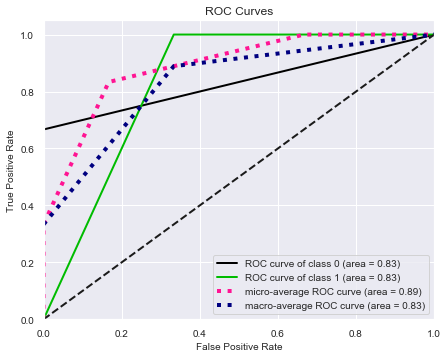

In [93]:
#Predicting probabilities for plotting the ROC curve
pred_proby = model.predict_proba(test_frontal_x)

import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(test_y, pred_proby, figsize=(7,5.5)) #Takes input as the ground truth labels and the predicted probabilities by algorithm
plt.savefig('F3_F4_random_forest_roc.jpg', dpi = 200)
plt.show()

## Naive Bayes

In [32]:
#Gaussian Naive Bayes
gnb = GaussianNB()
scores = cross_validate(gnb, train_frontal_x, train_y, cv=5, scoring= scoring)
print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
#model accuracy for validation sets  
#print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))

Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.3 0.24494897427831783
Recall 0.6 0.48989794855663565
F1 Score 0.4 0.3265986323710904


In [33]:
#Since there are no parameters to be tuned, we simply fit on training set and test on the testing set
gnb.fit(train_frontal_x, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
#Testing of the model on the held out test set
pred_y = gnb.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



## KNN

In [35]:
#K-nearest neighbours
depths = range(1, 10)
f1 = []

for k in depths:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nk = ', k)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (k, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


k =  1
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

k =  2
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.2 0.4000000000000001
Recall 0.1 0.20000000000000004
F1 Score 0.13333333333333333 0.26666666666666666

k =  3
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

k =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  5
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

k =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  7
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.2 0.24494897427831783
Rec

In [36]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {1}


In [37]:
k = 1
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(train_frontal_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [38]:
#Testing of the model on the held out test set
pred_y = knn.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



## Decision Tree

In [39]:
#Decision Tree classifier 
depths = range(1, 30)
f1 = []

for depth in depths:
    decision_tree= DecisionTreeClassifier(max_depth = depth, random_state= 0)
    scores = cross_validate(decision_tree, train_frontal_x, train_y, cv=5, scoring= scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.6 0.2
Recall 1.0 0.0
F1 Score 0.7333333333333333 0.13333333333333336

Depth =  2
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.4216370213557839

Depth =  3
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Depth =  4
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Depth =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Depth =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.

In [40]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {1}


In [41]:
depth = 1
decision_tree= DecisionTreeClassifier(max_depth = depth, random_state=0)
decision_tree.fit(train_frontal_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [42]:
#Testing of the model on the held out test set
pred_y = decision_tree.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



## RBF SVM

In [43]:
#RBF kernel SVM
f1 = []
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

for depth in depths:
    model_svm_rbf = SVC(kernel = 'rbf', C = depth, gamma = 'auto')
    scores = cross_validate(model_svm_rbf, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  0.1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  1.0
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 

In [44]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {0.1}


In [45]:
depth = 1.0
model_svm_rbf = SVC(kernel = 'rbf', C = depth, gamma = 'auto')
model_svm_rbf.fit(train_frontal_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
#Testing of the model on the held out test set
pred_y = model_svm_rbf.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



## Logistic Regression

In [47]:
#Logistic Regression
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2, 3]
f1 = []

for depth in depths:
    model_logistic = LogisticRegression(random_state=0, solver='lbfgs', C = depth)
    scores = cross_validate(model_logistic, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  0.1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  1.0
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 

In [48]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {0.1}


In [50]:
depth = 1
model_logistic = LogisticRegression(random_state=0, solver='lbfgs', C = depth)
model_logistic.fit(train_frontal_x, train_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
#Testing of the model on the held out test set
pred_y = model_logistic.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



## GBM

In [52]:
#GBM
n_trees =  range(1, 30)
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 = []
for lr in lrs:
    for n_tree in n_trees:
        model = GradientBoostingClassifier(random_state = 10, n_estimators=n_tree, learning_rate=lr, min_samples_split= 2,
                                        min_samples_leaf= 3 ,max_depth= 3, max_features=None,
                                        subsample=1)
        scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nLearning rate = ', lr, 'n_tree = ',  n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.01 n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  8
Accuracy 0.5666666666666667 0.0816

Accuracy 0.45 0.348010216963685
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.05 n_tree =  29
Accuracy 0.45 0.348010216963685
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.1 n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.1 n_tree =  2
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.1 n_tree =  3
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

Learning rate =  0.1 n_tree =  4
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

Learning rate =  0.1 n_tree =  5
Accuracy 0.5 0.33333333333333337
Precision 0.3 0.39999999999999997
Recall 0.4 0.4


Learning rate =  0.2 n_tree =  15
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.2 n_tree =  16
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.2 n_tree =  17
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.2 n_tree =  18
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.2 n_tree =  19
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.3999999


Learning rate =  0.3 n_tree =  28
Accuracy 0.45 0.348010216963685
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.3 n_tree =  29
Accuracy 0.45 0.348010216963685
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.4 n_tree =  1
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 n_tree =  2
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 n_tree =  3
Accuracy 0.5666666666666667 0.3265986323710904
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 n_tre


Learning rate =  0.5 n_tree =  10
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.5 n_tree =  11
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.5 n_tree =  12
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.5 n_tree =  13
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.5 n_tree =  14
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.3999999


Learning rate =  0.6 n_tree =  20
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.6 n_tree =  21
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.6 n_tree =  22
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.6 n_tree =  23
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.6 n_tree =  24
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.3999999


Learning rate =  0.8 n_tree =  4
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.8 n_tree =  5
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.8 n_tree =  6
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Learning rate =  0.8 n_tree =  7
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.8 n_tree =  8
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Le


Learning rate =  0.9 n_tree =  16
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.9 n_tree =  17
Accuracy 0.45 0.348010216963685
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.9 n_tree =  18
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.9 n_tree =  19
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  0.9 n_tree =  20
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 S


Learning rate =  1 n_tree =  28
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846

Learning rate =  1 n_tree =  29
Accuracy 0.5166666666666666 0.3511884584284246
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.39191835884530846


In [53]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for n_tree in n_trees:
        list_.append([lr, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [1, 1]


In [54]:
n_tree =  1
lr = 1
model = GradientBoostingClassifier(random_state = 10, n_estimators=n_tree, learning_rate=lr, min_samples_split= 2,
                                        min_samples_leaf= 3 ,max_depth= 3, max_features=None,
                                        subsample=1)
model.fit(train_frontal_x, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [55]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



## XGBoost

In [56]:
#XGBoost
n_trees = range(1, 30)
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 = []
for lr in lrs:
    for n_tree in n_trees:
        model = XGBClassifier(learning_rate = lr, max_depth = 10, alpha = 10, n_estimators = n_tree,\
                              subsample = 0.3, random_state= 0)
        scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nLearning rate = ', lr, ' n_tree = ', n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.01  n_tree =  1
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.4333333333333333 0.08164965809277261
Recall 1.0 0.0
F1 Score 0.5999999999999999 0.0816496580927726

Learning rate =  0.01  n_tree =  2
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.01  n_tree =  3
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.01  n_tree =  4
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.01  n_tree =  5
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.01  n_tree =  6
Accuracy 0.


Learning rate =  0.05  n_tree =  17
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.05  n_tree =  18
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.05  n_tree =  19
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.05  n_tree =  20
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.05  n_tree =  21
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.05  n_tree =  22
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783




Learning rate =  0.2  n_tree =  6
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.2  n_tree =  7
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.2  n_tree =  8
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.2  n_tree =  9
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.2  n_tree =  10
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.2  n_tree =  11
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learnin


Learning rate =  0.3  n_tree =  24
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.3  n_tree =  25
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.3  n_tree =  26
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.3  n_tree =  27
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.3  n_tree =  28
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate 


Learning rate =  0.5  n_tree =  13
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.5  n_tree =  14
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.5  n_tree =  15
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.5  n_tree =  16
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.3333333333333333 0.18257418583505539
Recall 0.8 0.4000000000000001
F1 Score 0.4666666666666666 0.24494897427831783

Learning rate =  0.5  n_tree =  17
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.5  n_tree =  18
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000


Learning rate =  0.7  n_tree =  2
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.7  n_tree =  3
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.7  n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.7  n_tree =  5
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.7  n_tree =  6
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.7  n_tree =  7
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.1333333333333


Learning rate =  0.8  n_tree =  20
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.8  n_tree =  21
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.8  n_tree =  22
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.2333333333333333 0.2
Recall 0.6 0.48989794855663565
F1 Score 0.3333333333333333 0.27888667551135854

Learning rate =  0.8  n_tree =  23
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.13333333333333333 0.1632993161855452
Recall 0.4 0.48989794855663565
F1 Score 0.2 0.24494897427831783

Learning rate =  0.8  n_tree =  24
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  0.8  n_tree =  25
Accuracy 0.43333333333333


Learning rate =  1  n_tree =  7
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  1  n_tree =  8
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.20000000000000004

Learning rate =  1  n_tree =  9
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  1  n_tree =  10
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.2 0.24494897427831783
Recall 0.4 0.48989794855663565
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1  n_tree =  11
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.2 0.24494897427831783
Recall 0.4 0.48989794855663565
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1  n_tree =  12
Accuracy 0.4333333333333333 0.08164965809277261
Precision 0.3333333333333333 0.18257418

In [57]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for n_tree in n_trees:
        list_.append([lr, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [0.01, 1]


In [58]:
lr = 0.01
n_tree = 1
model = XGBClassifier(learning_rate = lr, max_depth = 10, alpha = 10, n_estimators = n_tree, subsample = 0.3, random_state= 0)
model.fit(train_frontal_x, train_y)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)

In [59]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



## Adaboost

In [60]:
#Adaboost
n_trees = range(1, 30) #[4] #
depths = range(1, 30)
lrs = [0.2, 0.4, 0.6, 0.8, 1] #[0.05] #
f1 = []
for lr in lrs:
    for depth in depths:
        for tree in n_trees:
            model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=tree, max_depth = depth, random_state = 0), n_estimators=3, learning_rate=lr, random_state=10)
            scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
            print ('\nLearning rate = ', lr, 'depth = ', depth, 'n_tree = ', tree)
            print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
            print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
            print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
            print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
            f1.append(scores['test_f1_score'].mean())
            #model accuracy for validation sets  
            #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.2 depth =  1 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Learning rate =  0.2 depth =  1 n_tree =  2
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Learning rate =  0.2 depth =  1 n_tree =  3
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  1 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.36666666666666664 0.3711842908553348
Recall 0.5 0.4472135954999579
F1 Score 0.4133333333333333 0.38735570790223867

Learning rate =  0.2 depth =  1 n_tree =  5
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.4666666666666666 0.3231786571610887
Reca


Learning rate =  0.2 depth =  2 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  2 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  2 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  2 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  2 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666


Learning rate =  0.2 depth =  3 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  3 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  3 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  3 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  3 n_tree =  23
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.266


Learning rate =  0.2 depth =  4 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  4 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  5 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.2 depth =  5 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.2 depth =  5 n_tree =  3
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F


Learning rate =  0.2 depth =  6 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  6 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  6 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  6 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  6 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666


Learning rate =  0.2 depth =  7 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  7 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  7 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  7 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  7 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.166


Learning rate =  0.2 depth =  8 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  8 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  8 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  8 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  9 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 


Learning rate =  0.2 depth =  10 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  10 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  10 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  10 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  10 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.

Learning rate =  0.2 depth =  11 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  11 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  11 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  11 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  11 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.2 depth =  12 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  12 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  12 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  12 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  12 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precisio


Learning rate =  0.2 depth =  14 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  14 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  14 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  14 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  14 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26

Learning rate =  0.2 depth =  15 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  15 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  15 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  15 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  15 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26


Learning rate =  0.2 depth =  16 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  16 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  16 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  16 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  16 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666666666


Learning rate =  0.2 depth =  18 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.2 depth =  18 n_tree =  3
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.3 0.39999999999999997

Learning rate =  0.2 depth =  18 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  18 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  18 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997


Learning rate =  0.2 depth =  19 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  19 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  19 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  19 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  19 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16


Learning rate =  0.2 depth =  20 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  20 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  20 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  20 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  20 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666666666


Learning rate =  0.2 depth =  21 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  22 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.2 depth =  22 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.2 depth =  22 n_tree =  3
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.3 0.39999999999999997

Learning rate =  0.2 depth =  22 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27


Learning rate =  0.2 depth =  23 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  23 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  23 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  23 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  23 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2


Learning rate =  0.2 depth =  24 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  24 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  24 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  24 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  24 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision


Learning rate =  0.2 depth =  25 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  25 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  25 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  26 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.2 depth =  26 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.400000000


Learning rate =  0.2 depth =  27 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  27 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  27 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  27 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  27 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.


Learning rate =  0.2 depth =  28 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  28 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  28 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  28 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.2 depth =  28 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision


Learning rate =  0.2 depth =  29 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  29 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.2 depth =  29 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  1 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Learning rate =  0.4 depth =  1 n_tree =  2
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.26666666666666666 0.2260776


Learning rate =  0.4 depth =  2 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  2 n_tree =  8
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  2 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  2 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  2 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.266666


Learning rate =  0.4 depth =  3 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  3 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  3 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  3 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  3 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.1666


Learning rate =  0.4 depth =  4 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  4 n_tree =  26
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  4 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  4 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  4 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision


Learning rate =  0.4 depth =  6 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  6 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  6 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  6 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  6 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666


Learning rate =  0.4 depth =  7 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  7 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  7 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  7 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  7 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.1666


Learning rate =  0.4 depth =  8 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  8 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  8 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  8 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  8 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0


Learning rate =  0.4 depth =  10 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  10 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  10 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  10 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  10 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.

Learning rate =  0.4 depth =  11 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  11 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  11 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  11 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  11 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.4 depth =  12 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  12 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  12 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  12 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  12 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precisio


Learning rate =  0.4 depth =  14 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  14 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  14 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  14 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  14 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26


Learning rate =  0.4 depth =  15 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  15 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  15 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  15 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  15 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.4 depth =  16 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  16 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  16 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  16 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  16 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  0.4 depth =  18 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  18 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  18 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  18 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  18 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26


Learning rate =  0.4 depth =  19 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  19 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  19 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  19 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  19 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2


Learning rate =  0.4 depth =  20 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  20 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  20 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  20 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  20 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666666666

Learning rate =  0.4 depth =  22 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4 depth =  22 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.4 depth =  22 n_tree =  3
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.3 0.39999999999999997

Learning rate =  0.4 depth =  22 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  22 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.279999


Learning rate =  0.4 depth =  23 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  23 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  23 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  23 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  23 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26

Learning rate =  0.4 depth =  24 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  24 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  24 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  24 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  24 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 


Learning rate =  0.4 depth =  25 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  25 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  25 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  26 n_tree =  1
Accuracy 0.4666666666666666 0.2449489742783178
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4 depth =  26 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.400000000


Learning rate =  0.4 depth =  27 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  27 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  27 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  27 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  27 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.


Learning rate =  0.4 depth =  28 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  28 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  28 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  28 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.4 depth =  28 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision


Learning rate =  0.4 depth =  29 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  29 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.4 depth =  29 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  1 n_tree =  1
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Learning rate =  0.6 depth =  1 n_tree =  2
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.36666666666666664 0.1943650

Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  2 n_tree =  8
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  2 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  2 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  2 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.


Learning rate =  0.6 depth =  3 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  3 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  3 n_tree =  18
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  3 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  3 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.1666


Learning rate =  0.6 depth =  4 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  4 n_tree =  26
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  4 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  4 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  4 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision


Learning rate =  0.6 depth =  6 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  6 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  6 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  6 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  6 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666


Learning rate =  0.6 depth =  7 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  7 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  7 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  7 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  7 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.1666


Learning rate =  0.6 depth =  8 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  8 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  8 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  8 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  8 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0


Learning rate =  0.6 depth =  10 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  10 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  10 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  10 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  10 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.


Learning rate =  0.6 depth =  11 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  11 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  11 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  11 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  11 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0


Learning rate =  0.6 depth =  12 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  12 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  12 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  12 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  12 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precisio


Learning rate =  0.6 depth =  14 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  14 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  14 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  14 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  14 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.6 depth =  15 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  15 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  15 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  15 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  15 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.6 depth =  16 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  16 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  16 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  16 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  16 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  0.6 depth =  18 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  18 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  18 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  18 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  18 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.6 depth =  19 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  19 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  19 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  19 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  19 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2


Learning rate =  0.6 depth =  20 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  20 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  20 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  20 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  20 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  0.6 depth =  22 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  22 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  22 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  22 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  22 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.6 depth =  23 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  23 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  23 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  23 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  23 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.6 depth =  24 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  24 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  24 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  24 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  24 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  0.6 depth =  26 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  26 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  26 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  26 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  26 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.6 depth =  27 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  27 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  27 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  27 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  27 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2


Learning rate =  0.6 depth =  28 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  28 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.6 depth =  28 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  28 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.6 depth =  28 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666666666


Learning rate =  0.8 depth =  1 n_tree =  2
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  1 n_tree =  3
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.06666666666666667 0.13333333333333333
Recall 0.1 0.20000000000000004
F1 Score 0.08 0.16

Learning rate =  0.8 depth =  1 n_tree =  4
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  1 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  1 n_tree =  6
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.26666666666666666 0.2260776661041756


Learning rate =  0.8 depth =  2 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  2 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  2 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  2 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  2 n_tree =  15
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666666


Learning rate =  0.8 depth =  3 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  3 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  3 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  3 n_tree =  23
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  3 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.2666


Learning rate =  0.8 depth =  4 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  5 n_tree =  1
Accuracy 0.39999999999999997 0.2260776661041756
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.8 depth =  5 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.8 depth =  5 n_tree =  3
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.3 0.39999999999999997

Learning rate =  0.8 depth =  5 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.279999


Learning rate =  0.8 depth =  6 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  6 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  6 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  6 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  6 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.266666


Learning rate =  0.8 depth =  7 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  7 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  7 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  7 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  7 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16


Learning rate =  0.8 depth =  8 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  8 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  8 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  9 n_tree =  1
Accuracy 0.39999999999999997 0.2260776661041756
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.8 depth =  9 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.4000000000000


Learning rate =  0.8 depth =  10 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  10 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  10 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  10 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  10 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.


Learning rate =  0.8 depth =  11 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  11 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  11 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  11 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  11 n_tree =  22
Accuracy 0.41666666666666663 0.2581988897471611
Precision


Learning rate =  0.8 depth =  12 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  12 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  12 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  13 n_tree =  1
Accuracy 0.39999999999999997 0.2260776661041756
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.8 depth =  13 n_tree =  2
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.2 0.40000000


Learning rate =  0.8 depth =  14 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  14 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  14 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  14 n_tree =  11
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  14 n_tree =  12
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.

Learning rate =  0.8 depth =  15 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  15 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  15 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  15 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  15 n_tree =  21
Accuracy 0.41666666666666663 0.2581988897471611
Precision 


Learning rate =  0.8 depth =  16 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  16 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  16 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  16 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  17 n_tree =  1
Accuracy 0.39999999999999997 0.2260776661041756
Precisio


Learning rate =  0.8 depth =  18 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  18 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  18 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  18 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  18 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.


Learning rate =  0.8 depth =  19 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  19 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  19 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  19 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  19 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 


Learning rate =  0.8 depth =  20 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  20 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  20 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  20 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  20 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precisio


Learning rate =  0.8 depth =  22 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  22 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  22 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  22 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  22 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.8 depth =  23 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  23 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  23 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  23 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  23 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0


Learning rate =  0.8 depth =  24 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  24 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  24 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  24 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  24 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  0.8 depth =  26 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  26 n_tree =  5
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  26 n_tree =  6
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  26 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  26 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2


Learning rate =  0.8 depth =  27 n_tree =  13
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  27 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  27 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  27 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  27 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.


Learning rate =  0.8 depth =  28 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  0.8 depth =  28 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  28 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  28 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  0.8 depth =  28 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666666666


Learning rate =  1 depth =  1 n_tree =  4
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  1 n_tree =  5
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.4 0.37416573867739417
Recall 0.6 0.48989794855663565
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  6
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Learning rate =  1 depth =  1 n_tree =  7
Accuracy 0.5166666666666666 0.15275252316519466
Precision 0.26666666666666666 0.22607766610417562
Recall 0.5 0.4472135954999579
F1 Score 0.3466666666666667 0.2993325909419153

Learning rate =  1 depth =  1 n_tree =  8
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39


Learning rate =  1 depth =  2 n_tree =  15
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  2 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  2 n_tree =  17
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  2 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  2 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.166666666666666


Learning rate =  1 depth =  3 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  3 n_tree =  25
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  3 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  3 n_tree =  27
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  3 n_tree =  28
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666


Learning rate =  1 depth =  5 n_tree =  6
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  5 n_tree =  7
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  5 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  5 n_tree =  9
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  5 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 


Learning rate =  1 depth =  6 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  6 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  6 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  6 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  6 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.1666666666666


Learning rate =  1 depth =  7 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  7 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  7 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  7 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  7 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666


Learning rate =  1 depth =  9 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  9 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  9 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  9 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  9 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.388730126


Learning rate =  1 depth =  10 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  10 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  10 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  10 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  10 n_tree =  20
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666


Learning rate =  1 depth =  11 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  11 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  11 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  11 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  11 n_tree =  29
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.2666


Learning rate =  1 depth =  13 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  13 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  13 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  13 n_tree =  9
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  13 n_tree =  10
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.3887


Learning rate =  1 depth =  14 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  14 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  14 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  14 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  14 n_tree =  19
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666


Learning rate =  1 depth =  15 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  15 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  15 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  15 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  15 n_tree =  28
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.266666


Learning rate =  1 depth =  17 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  17 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  17 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  17 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  17 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.388730


Learning rate =  1 depth =  18 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  18 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  18 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  18 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  18 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.166666666


Learning rate =  1 depth =  19 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  19 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  19 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  19 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  19 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38


Learning rate =  1 depth =  21 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  21 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  21 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  21 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  21 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.388730


Learning rate =  1 depth =  22 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  22 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  22 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  22 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  22 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.166666666


Learning rate =  1 depth =  23 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  23 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  23 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  23 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  23 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38


Learning rate =  1 depth =  25 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  25 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  25 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  25 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  25 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.388730


Learning rate =  1 depth =  26 n_tree =  14
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  26 n_tree =  15
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  26 n_tree =  16
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  26 n_tree =  17
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  26 n_tree =  18
Accuracy 0.41666666666666663 0.2581988897471611
Precision 0.166666666


Learning rate =  1 depth =  27 n_tree =  23
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  27 n_tree =  24
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  27 n_tree =  25
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  27 n_tree =  26
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  27 n_tree =  27
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38


Learning rate =  1 depth =  29 n_tree =  4
Accuracy 0.5833333333333333 0.24720661623652207
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  29 n_tree =  5
Accuracy 0.4833333333333333 0.3431876713662333
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  29 n_tree =  6
Accuracy 0.35 0.2260776661041756
Precision 0.16666666666666666 0.21081851067789198
Recall 0.3 0.39999999999999997
F1 Score 0.21333333333333332 0.2745501370929867

Learning rate =  1 depth =  29 n_tree =  7
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.38873012632302006
Recall 0.3 0.39999999999999997
F1 Score 0.27999999999999997 0.3919183588453085

Learning rate =  1 depth =  29 n_tree =  8
Accuracy 0.41666666666666663 0.33333333333333337
Precision 0.26666666666666666 0.388730

In [61]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for depth in depths:
        for tree in n_trees:
            list_.append([lr, depth, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [0.2, 1, 1]


In [62]:
lr = 0.2
depth = 1
tree = 1
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=tree, max_depth = depth, random_state = 0), \
                           n_estimators=3, learning_rate=lr, random_state=10)
model.fit(train_frontal_x, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          learning_rate=0.2, n_estimators=3, random_state=10)

In [63]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



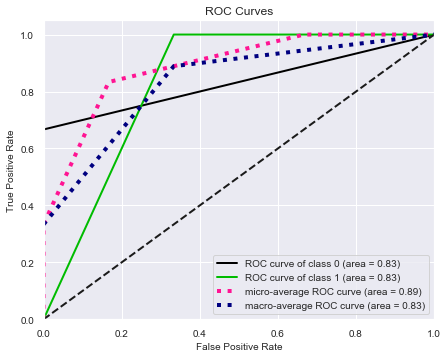

In [94]:
#Predicting probabilities for plotting the ROC curve
pred_proby = model.predict_proba(test_frontal_x)

import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(test_y, pred_proby, figsize=(7,5.5)) #Takes input as the ground truth labels and the predicted probabilities by algorithm
plt.savefig('F3_F4_adaboost_roc.jpg', dpi = 200)
plt.show()